In [1]:
#para instalar cv2 fazer pip install opencv-python
import cv2
import pandas as pd
import numpy as np
import os
import json
from tqdm import tqdm, tqdm_notebook
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD, RMSprop, Adam
import matplotlib.pyplot as plt
import pickle

Using TensorFlow backend.


In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.count()

Type             14993
Name             13736
Age              14993
Breed1           14993
Breed2           14993
Gender           14993
Color1           14993
Color2           14993
Color3           14993
MaturitySize     14993
FurLength        14993
Vaccinated       14993
Dewormed         14993
Sterilized       14993
Health           14993
Quantity         14993
Fee              14993
State            14993
RescuerID        14993
VideoAmt         14993
Description      14981
PetID            14993
PhotoAmt         14993
AdoptionSpeed    14993
dtype: int64

In [4]:
#retirando colunas de nome e descrição, neste primeiro momento não faremos analise de sentimento.
df = df.drop(columns=['Description','State','RescuerID'])

In [5]:
df.head(5)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,VideoAmt,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,2,2,2,1,1,100,0,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,3,3,3,1,1,0,0,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,2,1,1,0,0,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,2,1,1,150,0,5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,2,2,2,1,1,0,0,850a43f90,3.0,2


In [6]:
#Como pretendemos criar uma rede neural que trate as imagens, os animais que não possuem foto serão excluídos da amostra
df = df[df.PhotoAmt != 0]

In [7]:
df.count()

Type             14652
Name             13455
Age              14652
Breed1           14652
Breed2           14652
Gender           14652
Color1           14652
Color2           14652
Color3           14652
MaturitySize     14652
FurLength        14652
Vaccinated       14652
Dewormed         14652
Sterilized       14652
Health           14652
Quantity         14652
Fee              14652
VideoAmt         14652
PetID            14652
PhotoAmt         14652
AdoptionSpeed    14652
dtype: int64

In [8]:
#Name: 2 classes (com nome e sem nome)
df['NameNew'] = ['1' if pd.notnull(x) else '2' for x in df['Name']]

#Age: 3 classes (até 3 meses, até 12 meses e acima de 12 meses)
df['AgeNew'] = ['1' if int(x)<=3 else('2' if (int(x)>3 and int(x)<=12) else '3') for x in df['Age']]

#Breed1: 3 classes
#Sem raça definida: breed 1 = 307, 266, 265, 299, 264
#Raça pura: breed 1 <> 307, 266, 265, 299, 264 e breed 2 = 0
#Raça misturada: breed 1 <> 307, 266, 265, 299, 264 e breed 2 <> 0
df['Breed1New'] = ['1' if x in['307','266','265','299','264'] else '2' for x in df['Breed1']]

#Color: 2 classes
#Quantidade de cores: 1 ou mais que 1
df['ColorQtde'] = ['1' if x == '0' else '2' for x in df['Color2']]
#Cor predominante: escura ou clara
df['ColorMain'] = ['1' if int(x) <= 2 else '2' for x in df['Color1']]
#MaturitySize: 3 classes (juntar 3-Large e 4-Extra large)
#1 = Small, 2 = Medium, 3 = Large
df['MaturitySizeNew'] = [x if x != '4' else '3' for x in df['MaturitySize']] 
#Health: 2 classes (saudável e não saudável)
df['HealthNew'] = [x if x != '3' else '2' for x in df['Health']] 
#Quantity: 2 classes (1 animal e mais de 1 animal)
df['QuantityNew'] = ['2' if int(x)>=2 else '1' for x in df['Quantity']]
#Fee: 2 classes (com taxa e sem taxa)
df['FeeNew'] = ['2' if int(x)>0 else '1' for x in df['Fee']]
#PhotoAmt: 2 classes (1 foto e mais de 1 foto)
df['PhotoAmtNew'] = ['1' if float(x)==1 else '2' for x in df['PhotoAmt']]
#Reduzindo número de classes AdoptionSpeed para 2, adotado e não adotado
df['AdoptionSpeedNew'] = ['2' if int(x)==4 else '1' for x in df['AdoptionSpeed']]

In [9]:
df[['AdoptionSpeed','AdoptionSpeedNew']]

,AdoptionSpeed,AdoptionSpeedNew
0,2,1
1,0,1
2,3,1
3,2,1
4,2,1
5,2,1
6,1,1
7,3,1
8,1,1
9,4,2


In [10]:
df = df.drop(columns=['Name','VideoAmt','Age','Breed1','Breed2','Color1','Color2','Color3','MaturitySize','Health','Quantity','Fee','PhotoAmt','AdoptionSpeed'])

In [11]:
df.columns
#Utilizaremos no modelo todas as colunas, e todos são categóricas   

Index(['Type', 'Gender', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized',
       'PetID', 'NameNew', 'AgeNew', 'Breed1New', 'ColorQtde', 'ColorMain',
       'MaturitySizeNew', 'HealthNew', 'QuantityNew', 'FeeNew', 'PhotoAmtNew',
       'AdoptionSpeedNew'],
      dtype='object')

In [12]:
df.count()

Type                14652
Gender              14652
FurLength           14652
Vaccinated          14652
Dewormed            14652
Sterilized          14652
PetID               14652
NameNew             14652
AgeNew              14652
Breed1New           14652
ColorQtde           14652
ColorMain           14652
MaturitySizeNew     14652
HealthNew           14652
QuantityNew         14652
FeeNew              14652
PhotoAmtNew         14652
AdoptionSpeedNew    14652
dtype: int64

In [13]:
print(df[df.AdoptionSpeedNew == '1'].count())
print(df[df.AdoptionSpeedNew == '2'].count())

Type                10668
Gender              10668
FurLength           10668
Vaccinated          10668
Dewormed            10668
Sterilized          10668
PetID               10668
NameNew             10668
AgeNew              10668
Breed1New           10668
ColorQtde           10668
ColorMain           10668
MaturitySizeNew     10668
HealthNew           10668
QuantityNew         10668
FeeNew              10668
PhotoAmtNew         10668
AdoptionSpeedNew    10668
dtype: int64
Type                3984
Gender              3984
FurLength           3984
Vaccinated          3984
Dewormed            3984
Sterilized          3984
PetID               3984
NameNew             3984
AgeNew              3984
Breed1New           3984
ColorQtde           3984
ColorMain           3984
MaturitySizeNew     3984
HealthNew           3984
QuantityNew         3984
FeeNew              3984
PhotoAmtNew         3984
AdoptionSpeedNew    3984
dtype: int64


In [14]:
#fazendo split da base
msk = np.random.rand(len(df)) < 0.8
train_df = df[msk]
test_df = df[~msk]

In [15]:
print(train_df.shape)
print(test_df.shape)

(11690, 18)
(2962, 18)


In [16]:
#Verificando se bases estão balanceadas
print(train_df[train_df.AdoptionSpeedNew == '1'].count())
print(train_df[train_df.AdoptionSpeedNew == '2'].count())
print(test_df[test_df.AdoptionSpeedNew == '1'].count())
print(test_df[test_df.AdoptionSpeedNew == '2'].count())

Type                8493
Gender              8493
FurLength           8493
Vaccinated          8493
Dewormed            8493
Sterilized          8493
PetID               8493
NameNew             8493
AgeNew              8493
Breed1New           8493
ColorQtde           8493
ColorMain           8493
MaturitySizeNew     8493
HealthNew           8493
QuantityNew         8493
FeeNew              8493
PhotoAmtNew         8493
AdoptionSpeedNew    8493
dtype: int64
Type                3197
Gender              3197
FurLength           3197
Vaccinated          3197
Dewormed            3197
Sterilized          3197
PetID               3197
NameNew             3197
AgeNew              3197
Breed1New           3197
ColorQtde           3197
ColorMain           3197
MaturitySizeNew     3197
HealthNew           3197
QuantityNew         3197
FeeNew              3197
PhotoAmtNew         3197
AdoptionSpeedNew    3197
dtype: int64
Type                2175
Gender              2175
FurLength           2175

In [17]:
#Tratando as features para serem utilizadas na rede neural
#Categóricas
labels = ['Type', 'Gender', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized','NameNew', 'AgeNew', 'Breed1New', 'ColorQtde','ColorMain', 'MaturitySizeNew', 'HealthNew', 'QuantityNew', 'FeeNew','PhotoAmtNew','AdoptionSpeedNew']         

In [18]:
train_df[labels].head(10)

,Type,Gender,FurLength,Vaccinated,Dewormed,Sterilized,NameNew,AgeNew,Breed1New,ColorQtde,ColorMain,MaturitySizeNew,HealthNew,QuantityNew,FeeNew,PhotoAmtNew,AdoptionSpeedNew
0,2,1,1,2,2,2,1,1,2,2,1,1,1,1,2,1,1
1,2,1,2,3,3,3,1,1,2,2,1,2,1,1,1,2,1
2,1,1,2,1,1,2,1,1,2,2,1,2,1,1,1,2,1
4,1,1,1,2,2,2,1,1,2,2,1,2,1,1,1,2,1
5,2,2,1,2,2,2,2,1,2,2,2,2,1,1,1,2,1
6,2,1,3,2,2,3,1,2,2,2,1,2,1,1,2,2,1
7,1,2,1,2,2,2,1,1,2,2,1,2,1,2,1,2,1
8,2,2,2,2,2,2,2,1,2,2,2,2,1,1,1,2,1
9,2,2,2,3,3,3,1,2,2,2,1,2,1,1,1,2,2
10,1,1,1,2,1,2,1,1,2,2,1,2,1,1,1,2,1


In [19]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

for a in labels:
    lb.fit(df[a])
    train_df[a] = lb.transform(train_df[a])
    test_df[a] = lb.transform(test_df[a])

c:\users\majin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\majin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
c:\users\majin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

c:\users\majin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\majin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
c:\users\majin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [20]:
#criando o nome do modelo
filename = 'binarizer_model.sav'

In [21]:
#gravando o modelo no pickle
pickle.dump(lb, open(filename, 'wb'))

In [22]:
train_df[labels].head(10)


,Type,Gender,FurLength,Vaccinated,Dewormed,Sterilized,NameNew,AgeNew,Breed1New,ColorQtde,ColorMain,MaturitySizeNew,HealthNew,QuantityNew,FeeNew,PhotoAmtNew,AdoptionSpeedNew
0,1,1,1,0,0,0,0,1,0,0,0,1,1,0,1,0,0
1,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
2,0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0
4,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0
5,1,0,1,0,0,0,1,1,0,0,1,0,1,0,0,1,0
6,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0
7,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,1,0
8,1,0,0,0,0,0,1,1,0,0,1,0,1,0,0,1,0
9,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
10,0,1,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0


In [23]:
train_df.columns

Index(['Type', 'Gender', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized',
       'PetID', 'NameNew', 'AgeNew', 'Breed1New', 'ColorQtde', 'ColorMain',
       'MaturitySizeNew', 'HealthNew', 'QuantityNew', 'FeeNew', 'PhotoAmtNew',
       'AdoptionSpeedNew'],
      dtype='object')

In [24]:
X_train = train_df.loc[:,['Type',
       'Gender', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized',
       'NameNew', 'AgeNew', 'Breed1New', 'ColorQtde',
       'ColorMain', 'MaturitySizeNew', 'HealthNew', 'QuantityNew', 'FeeNew',
       'PhotoAmtNew']]
y_train = train_df.loc[:,['AdoptionSpeedNew']]

X_test = test_df.loc[:,['Type',
       'Gender', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized',
       'NameNew', 'AgeNew', 'Breed1New', 'ColorQtde',
       'ColorMain', 'MaturitySizeNew', 'HealthNew', 'QuantityNew', 'FeeNew',
       'PhotoAmtNew']]
y_test = test_df.loc[:,['AdoptionSpeedNew']]



In [25]:
print(train_df.shape)
print(test_df.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(11690, 18)
(2962, 18)
(11690, 16)
(2962, 16)
(11690, 1)
(2962, 1)


In [26]:
num_classes = 2
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes) 

In [27]:
y_test

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [28]:
from keras.layers import Input, Dense
from keras.models import Model
inputs = Input(shape=(16,))
x = Dense(32, activation="relu")(inputs)
x = Dropout((0.2))(x)
x = Dense(32, activation="relu")(x)
x = Dropout((0.2))(x)

#Documentado pois rodaremos essa ultima saida no combined input
#x = Dense(num_classes, activation="softmax")(x)

modelmlp = Model(inputs, x)


modelmlp.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
Total params: 1,600
Trainable params: 1,600
Non-trainable params: 0
___________________

#Rodar apenas se não estiver usando modelo combinado
modelmlp.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

#Rodar apenas se não estiver usando modelo combinado
history = modelmlp.fit(X_train, y_train,
                    batch_size=32,
                    epochs=20,
                    verbose=1,
                    validation_data=(X_test, y_test))

#Rodar apenas se não estiver usando modelo combinado
score = modelmlp.evaluate(X_test, y_test, verbose=0)

#Rodar apenas se não estiver usando modelo combinado
print('Test accuracy:', score[1])

#Rodar apenas se não estiver usando modelo combinado
preds = modelmlp.predict([X_test])

#Rodar apenas se não estiver usando modelo combinado
data_test = test_df
data_test['prob0'] = preds[:,0]
data_test['prob1'] = preds[:,1]
data_test[['PetID','AdoptionSpeedNew','prob0','prob1']].head(1000)

#Rodar apenas se não estiver usando modelo combinado
#animais da base de teste que provavelmente não serão adotados
k = data_test[data_test.prob1 >0.5][['PetID','AdoptionSpeedNew']]
k[k.AdoptionSpeedNew == 1] #242
k.count() #440
#55% de acerto

#Rodar apenas se não estiver usando modelo combinado
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()


#Rodar apenas se não estiver usando modelo combinado
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [29]:
img_size = 128
def resize_to_square(im):
    old_size = im.shape[:2]
    ratio = float(img_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])    
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = img_size - new_size[1]
    delta_h = img_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    return new_im

In [30]:
#Agora trabalhando com as imagens base treino
images_train = []
path = "train_images/"
for i in train_df['PetID']:
    try:
        im = cv2.imread(f'{path}{i}-1.jpg')
        im = resize_to_square(im)
        print(im.shape)
        images_train.append(im)
    except:
        pass
images_train = np.asarray(images_train)

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

In [31]:
#Agora trabalhando também com as imagens base teste
images_test = []
path = "train_images/"
for i in test_df['PetID']:
    try:
        im = cv2.imread(f'{path}{i}-1.jpg')
        im = resize_to_square(im)
       # print(im.shape)
        images_test.append(im)
    except:
        pass
images_test = np.asarray(images_test)

In [32]:
print(images_train.shape)
print(images_test.shape)
print(train_df.shape)
print(test_df.shape)

(11690, 128, 128, 3)
(2962, 128, 128, 3)
(11690, 18)
(2962, 18)


(480, 371)
AxesImage(54,36;334.8x217.44)
AxesImage(54,36;334.8x217.44)
(128, 128)


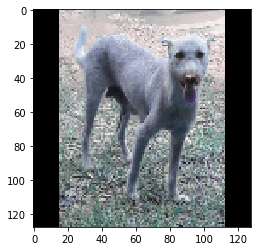

In [33]:
im1 = cv2.imread(f'{path}eb652ec07-1.jpg')
print(im1.shape[:2])
print(plt.imshow(im1))
im2 = resize_to_square(im1)
print(plt.imshow(im2))
print(im2.shape[:2])

In [34]:
#CNN para leitura predição das imagens
from keras.layers.normalization import BatchNormalization

inputShape = (128, 128, 3)
InputCN = Input(shape=inputShape)
x = Conv2D(32, (3, 3), padding="same")(InputCN)
x = Activation("relu")(x)
x = BatchNormalization(axis= -1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, (3, 3), padding="same")(x)
x = Activation("relu")(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (3, 3), padding="same")(x)
x = Activation("relu")(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# flatten the volume, then FC => RELU => BN => DROPOUT
x = Flatten()(x)
x = Dense(32)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
#Documentado pois rodaremos essa ultima saida no modelo combinado
#x = Dense(num_classes, activation="softmax")(x)
# construct the CNN
modelcnn = Model(InputCN, x)
modelcnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 64)        0         
__________

In [35]:
images_train = images_train/255.0
images_test = images_test/255.0

#Rodar apenas se não estiver usando modelo combinado
modelcnn.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

#Rodar apenas se não estiver usando modelo combinado
history = modelcnn.fit(images_train, y_train,
                    batch_size=32,
                    epochs=20,
                    verbose=1,
                    validation_data=(images_test, y_test))


#Rodar apenas se não estiver usando modelo combinado
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()


#Rodar apenas se não estiver usando modelo combinado
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

#Rodar apenas se não estiver usando modelo combinado
score = modelcnn.evaluate(images_test, y_test, verbose=0)
print('Test accuracy:', score[1])


#Rodar apenas se não estiver usando modelo combinado
preds = modelcnn.predict([images_test])

#Rodar apenas se não estiver usando modelo combinado
#animais da base de teste que provavelmente não serão adotados
data_testim = test_df
data_testim['prob'] = preds[:,-1]
data_testim[data_testim.prob >0.2][['PetID','AdoptionSpeedNew']]
#j[j.AdoptionSpeedNew == 1] #391
#j.count() #1449

#k = data_test[data_test.prob1 >0.5][['PetID','AdoptionSpeedNew']]
#k[k.AdoptionSpeedNew == 1] #242
#k.count() #440
#55% de acerto


In [36]:
from keras.layers import concatenate
combinedInput = concatenate([modelmlp.output, modelcnn.output])
cx = Dense(4, activation="relu")(combinedInput)
cx = Dense(num_classes, activation="softmax")(cx)


In [37]:
model = Model(inputs=[modelmlp.input, modelcnn.input], outputs=cx)

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [38]:
history = model.fit([X_train, images_train], y_train,
                    batch_size=32,
                    epochs=4,
                    verbose=1,
                    validation_data=([X_test, images_test], y_test))

Instructions for updating:
Use tf.cast instead.
Train on 11690 samples, validate on 2962 samples
Epoch 1/4


 6528/11690 [===============>..............] - ETA: 22:00 - loss: 0.9739 - acc: 0.68 - ETA: 19:57 - loss: 3.2041 - acc: 0.54 - ETA: 19:08 - loss: 2.8586 - acc: 0.57 - ETA: 18:37 - loss: 2.4208 - acc: 0.60 - ETA: 18:16 - loss: 2.1460 - acc: 0.59 - ETA: 18:12 - loss: 1.9283 - acc: 0.61 - ETA: 18:01 - loss: 1.8084 - acc: 0.62 - ETA: 17:51 - loss: 1.7747 - acc: 0.61 - ETA: 17:40 - loss: 1.6676 - acc: 0.62 - ETA: 17:30 - loss: 1.5461 - acc: 0.63 - ETA: 17:23 - loss: 1.5923 - acc: 0.63 - ETA: 17:15 - loss: 1.5661 - acc: 0.63 - ETA: 17:10 - loss: 1.5090 - acc: 0.63 - ETA: 17:05 - loss: 1.5301 - acc: 0.62 - ETA: 16:59 - loss: 1.5749 - acc: 0.61 - ETA: 16:54 - loss: 1.5484 - acc: 0.62 - ETA: 16:49 - loss: 1.4947 - acc: 0.63 - ETA: 16:46 - loss: 1.5535 - acc: 0.63 - ETA: 16:43 - loss: 1.5940 - acc: 0.62 - ETA: 16:40 - loss: 1.6296 - acc: 0.62 - ETA: 16:38 - loss: 1.6504 - acc: 0.63 - ETA: 16:35 - loss: 1.6277 - acc: 0.63 - ETA: 16:30 - loss: 1.5975 - acc: 0.63 - ETA: 16:27 - loss: 1.5716 - acc: 

 6528/11690 [===============>..............] - ETA: 16:54 - loss: 0.5758 - acc: 0.75 - ETA: 17:27 - loss: 0.9399 - acc: 0.76 - ETA: 17:08 - loss: 0.8719 - acc: 0.71 - ETA: 17:26 - loss: 0.8066 - acc: 0.71 - ETA: 17:19 - loss: 0.7606 - acc: 0.72 - ETA: 17:23 - loss: 0.7301 - acc: 0.71 - ETA: 17:17 - loss: 0.7083 - acc: 0.71 - ETA: 17:13 - loss: 0.6893 - acc: 0.72 - ETA: 17:08 - loss: 0.7050 - acc: 0.71 - ETA: 17:03 - loss: 0.6948 - acc: 0.71 - ETA: 16:59 - loss: 0.6801 - acc: 0.72 - ETA: 16:59 - loss: 0.6736 - acc: 0.71 - ETA: 16:59 - loss: 0.6620 - acc: 0.72 - ETA: 16:54 - loss: 0.6512 - acc: 0.73 - ETA: 16:53 - loss: 0.6517 - acc: 0.72 - ETA: 16:50 - loss: 0.6471 - acc: 0.72 - ETA: 16:46 - loss: 0.6406 - acc: 0.72 - ETA: 16:43 - loss: 0.6391 - acc: 0.72 - ETA: 16:39 - loss: 0.6431 - acc: 0.71 - ETA: 16:34 - loss: 0.6442 - acc: 0.71 - ETA: 16:32 - loss: 0.6381 - acc: 0.71 - ETA: 16:28 - loss: 0.6373 - acc: 0.71 - ETA: 16:24 - loss: 0.6347 - acc: 0.71 - ETA: 16:22 - loss: 0.6276 - acc: 

11690/11690 [==============================] - ETA: 7:37 - loss: 0.6737 - acc: 0.724 - ETA: 7:34 - loss: 0.6735 - acc: 0.724 - ETA: 7:31 - loss: 0.6730 - acc: 0.724 - ETA: 7:28 - loss: 0.6732 - acc: 0.723 - ETA: 7:25 - loss: 0.6726 - acc: 0.724 - ETA: 7:22 - loss: 0.6725 - acc: 0.723 - ETA: 7:20 - loss: 0.6715 - acc: 0.724 - ETA: 7:17 - loss: 0.6713 - acc: 0.724 - ETA: 7:14 - loss: 0.6713 - acc: 0.723 - ETA: 7:11 - loss: 0.6715 - acc: 0.722 - ETA: 7:08 - loss: 0.6712 - acc: 0.722 - ETA: 7:05 - loss: 0.6701 - acc: 0.723 - ETA: 7:03 - loss: 0.6702 - acc: 0.722 - ETA: 7:00 - loss: 0.6692 - acc: 0.723 - ETA: 6:57 - loss: 0.6691 - acc: 0.722 - ETA: 6:54 - loss: 0.6688 - acc: 0.722 - ETA: 6:51 - loss: 0.6679 - acc: 0.723 - ETA: 6:48 - loss: 0.6674 - acc: 0.723 - ETA: 6:45 - loss: 0.6669 - acc: 0.723 - ETA: 6:42 - loss: 0.6663 - acc: 0.723 - ETA: 6:40 - loss: 0.6667 - acc: 0.723 - ETA: 6:37 - loss: 0.6664 - acc: 0.723 - ETA: 6:34 - loss: 0.6661 - acc: 0.723 - ETA: 6:31 - loss: 0.6663 - acc: 0

 6528/11690 [===============>..............] - ETA: 17:19 - loss: 0.5729 - acc: 0.75 - ETA: 17:19 - loss: 0.6044 - acc: 0.70 - ETA: 17:21 - loss: 0.6291 - acc: 0.67 - ETA: 17:16 - loss: 0.6170 - acc: 0.67 - ETA: 17:12 - loss: 0.6148 - acc: 0.68 - ETA: 17:08 - loss: 0.6076 - acc: 0.68 - ETA: 17:08 - loss: 0.5838 - acc: 0.70 - ETA: 17:03 - loss: 0.5783 - acc: 0.71 - ETA: 16:57 - loss: 0.5612 - acc: 0.73 - ETA: 16:52 - loss: 0.5622 - acc: 0.73 - ETA: 16:50 - loss: 0.5619 - acc: 0.73 - ETA: 16:47 - loss: 0.5511 - acc: 0.75 - ETA: 16:46 - loss: 0.5450 - acc: 0.75 - ETA: 16:43 - loss: 0.5688 - acc: 0.73 - ETA: 16:40 - loss: 0.5618 - acc: 0.74 - ETA: 16:36 - loss: 0.5650 - acc: 0.73 - ETA: 16:33 - loss: 0.5638 - acc: 0.73 - ETA: 16:30 - loss: 0.5636 - acc: 0.73 - ETA: 16:30 - loss: 0.5677 - acc: 0.73 - ETA: 16:28 - loss: 0.5702 - acc: 0.73 - ETA: 16:23 - loss: 0.5733 - acc: 0.73 - ETA: 16:21 - loss: 0.5695 - acc: 0.73 - ETA: 16:17 - loss: 0.5723 - acc: 0.73 - ETA: 16:15 - loss: 0.5736 - acc: 

 6528/11690 [===============>..............] - ETA: 17:26 - loss: 0.6029 - acc: 0.65 - ETA: 17:18 - loss: 0.6471 - acc: 0.64 - ETA: 17:17 - loss: 0.6053 - acc: 0.69 - ETA: 17:13 - loss: 0.5765 - acc: 0.71 - ETA: 17:13 - loss: 0.5984 - acc: 0.70 - ETA: 17:12 - loss: 0.5851 - acc: 0.71 - ETA: 17:13 - loss: 0.5856 - acc: 0.71 - ETA: 17:12 - loss: 0.6021 - acc: 0.70 - ETA: 17:09 - loss: 0.5905 - acc: 0.71 - ETA: 17:09 - loss: 0.5878 - acc: 0.71 - ETA: 17:07 - loss: 0.5931 - acc: 0.70 - ETA: 17:02 - loss: 0.5878 - acc: 0.70 - ETA: 17:00 - loss: 0.5888 - acc: 0.70 - ETA: 16:57 - loss: 0.5804 - acc: 0.71 - ETA: 16:54 - loss: 0.5814 - acc: 0.71 - ETA: 16:52 - loss: 0.5832 - acc: 0.71 - ETA: 16:48 - loss: 0.5764 - acc: 0.71 - ETA: 16:44 - loss: 0.5709 - acc: 0.72 - ETA: 16:40 - loss: 0.5770 - acc: 0.71 - ETA: 16:37 - loss: 0.5856 - acc: 0.71 - ETA: 16:33 - loss: 0.5828 - acc: 0.71 - ETA: 16:30 - loss: 0.5870 - acc: 0.71 - ETA: 16:27 - loss: 0.5938 - acc: 0.70 - ETA: 16:25 - loss: 0.5896 - acc: 

11690/11690 [==============================] - ETA: 7:40 - loss: 0.5691 - acc: 0.735 - ETA: 7:37 - loss: 0.5695 - acc: 0.735 - ETA: 7:35 - loss: 0.5699 - acc: 0.734 - ETA: 7:32 - loss: 0.5692 - acc: 0.735 - ETA: 7:29 - loss: 0.5685 - acc: 0.735 - ETA: 7:26 - loss: 0.5692 - acc: 0.735 - ETA: 7:23 - loss: 0.5690 - acc: 0.735 - ETA: 7:20 - loss: 0.5688 - acc: 0.735 - ETA: 7:17 - loss: 0.5693 - acc: 0.735 - ETA: 7:14 - loss: 0.5688 - acc: 0.735 - ETA: 7:11 - loss: 0.5691 - acc: 0.734 - ETA: 7:08 - loss: 0.5692 - acc: 0.734 - ETA: 7:06 - loss: 0.5690 - acc: 0.734 - ETA: 7:03 - loss: 0.5695 - acc: 0.734 - ETA: 7:00 - loss: 0.5694 - acc: 0.734 - ETA: 6:57 - loss: 0.5694 - acc: 0.734 - ETA: 6:54 - loss: 0.5695 - acc: 0.734 - ETA: 6:51 - loss: 0.5696 - acc: 0.734 - ETA: 6:48 - loss: 0.5692 - acc: 0.734 - ETA: 6:45 - loss: 0.5688 - acc: 0.734 - ETA: 6:42 - loss: 0.5690 - acc: 0.734 - ETA: 6:40 - loss: 0.5690 - acc: 0.734 - ETA: 6:37 - loss: 0.5688 - acc: 0.734 - ETA: 6:34 - loss: 0.5685 - acc: 0

In [39]:
score = model.evaluate([X_test, images_test], y_test, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.7346387574754801


In [40]:
preds = model.predict([X_test, images_test])

In [41]:
preds.shape

(2962, 2)

In [42]:
preds

array([[0.62720525, 0.37279475],
       [0.8817424 , 0.11825754],
       [0.57386607, 0.4261339 ],
       ...,
       [0.5896106 , 0.41038948],
       [0.9099094 , 0.09009061],
       [0.6296935 , 0.37030652]], dtype=float32)

In [43]:
#Encontrando uma probabilidade de corte
data_test = test_df
data_test['prob'] = preds[:,-1]
i = 0.05

total = data_test.AdoptionSpeedNew.count()
totn_adotado = data_test[data_test.AdoptionSpeedNew == 1].AdoptionSpeedNew.count()
tot_adotado = data_test[data_test.AdoptionSpeedNew == 0].AdoptionSpeedNew.count()

print("Testando valores para faixa de corte que identificara no streaming o que vai ser adotado ou não")

print("O total de animais na base é ",total, ", com AdoptionSpeedNew == 1 é ",totn_adotado,", com AdoptionSpeedNew == 0 é",tot_adotado)

while (i <= 0.5):
    n_adotado = data_test[data_test.AdoptionSpeedNew == 1][data_test.prob >=i].AdoptionSpeedNew.count()
    adotado = data_test[data_test.AdoptionSpeedNew == 0][data_test.prob <i].AdoptionSpeedNew.count()
    print("Com a faixa de corte = ",i," na base de teste a precisão = ",(adotado + n_adotado)/total,", a precisão dentro do não adotado = ", n_adotado/totn_adotado,", a precisão dentro do adotado = ",adotado/tot_adotado)  
    i += 0.05

c:\users\majin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Testando valores para faixa de corte que identificara no streaming o que vai ser adotado ou não
O total de animais na base é  2962 , com AdoptionSpeedNew == 1 é  787 , com AdoptionSpeedNew == 0 é 2175


c:\users\majin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
c:\users\majin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


Com a faixa de corte =  0.05  na base de teste a precisão =  0.26806212018906145 , a precisão dentro do não adotado =  0.9987293519695044 , a precisão dentro do adotado =  0.0036781609195402297
Com a faixa de corte =  0.1  na base de teste a precisão =  0.3200540175557056 , a precisão dentro do não adotado =  0.9809402795425667 , a precisão dentro do adotado =  0.08091954022988505
Com a faixa de corte =  0.15000000000000002  na base de teste a precisão =  0.4216745442268737 , a precisão dentro do não adotado =  0.9263024142312579 , a precisão dentro do adotado =  0.23908045977011494
Com a faixa de corte =  0.2  na base de teste a precisão =  0.5195813639432816 , a precisão dentro do não adotado =  0.8449809402795425 , a precisão dentro do adotado =  0.4018390804597701
Com a faixa de corte =  0.25  na base de teste a precisão =  0.6046590141796083 , a precisão dentro do não adotado =  0.7306226175349428 , a precisão dentro do adotado =  0.5590804597701149
Com a faixa de corte =  0.3  na

In [44]:
#Faixa de corte obtida foi 0.3 onde apesar da precisão da base não ser a maior, 65% com 0.3 vs 73% com 0.45, é onde temos um equilibrio maior.
#animais da base de teste que provavelmente não serão adotados
data_testcomb = test_df
data_testcomb['prob'] = preds[:,-1]
l = data_testcomb[data_testcomb.prob >0.3][['PetID','AdoptionSpeedNew','prob']]
print(l[l.AdoptionSpeedNew == 1])
print(l.count())

c:\users\majin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


           PetID  AdoptionSpeedNew      prob
32     543130f60                 1  0.408481
94     dd308e46b                 1  0.426134
129    61ac3c78c                 1  0.311415
130    368b2adc1                 1  0.361774
156    c3f2f166d                 1  0.399567
182    ab4b4681b                 1  0.400155
204    c7b468b32                 1  0.384028
213    f4ed1a08e                 1  0.426134
273    d8715d47e                 1  0.359497
331    d096658bb                 1  0.357175
334    eb652ec07                 1  0.380960
365    86550c5dc                 1  0.316726
413    c390140c3                 1  0.426134
420    4831c683c                 1  0.353843
438    0eba8b0ad                 1  0.426134
454    9a9f6c753                 1  0.379647
489    d8128cefd                 1  0.334852
557    edf0ff7e4                 1  0.346812
578    fc9b4b692                 1  0.388499
580    487abc5e1                 1  0.423346
609    1e24f14d6                 1  0.397199
616    846

In [45]:
# sSalvndo modelo para JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# salvando pesos para HDF5
model.save_weights("model.h5")
print("Modelo salvo para disco")

Modelo salvo para disco


# Depois...
 
# Carregar json e criar modelo
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# Carregando pesos para o modelo
loaded_model.load_weights("model.h5")
print("Modelo carregado do disco")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = model.evaluate([X, images], y, verbose=0)
print('Test accuracy:', score[1])